In [155]:
from typing import Union, Optional, Dict, Tuple
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from fredapi import Fred
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer
from sklearn.decomposition import PCA
import ruptures as rpt

In [109]:
# pd.options.plotting.backend = "plotly"
pd.options.plotting.backend = "matplotlib"

FRED_API = os.getenv("FRED_API_KEY")
RANDOM_STATE = 42
START_DATE = '1996-01-01'
END_DATE = '2025-05-01'

# Macroeconomic data

**Including:** FED Fund Rates, CPI, PPI, GDP, Unemployment, Nonfarm payrolls

### Getting the data

In [97]:
fred = Fred(api_key=FRED_API)

def load_data(start: str, end: str):
    
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime('today') if end is None else pd.to_datetime(end)
    if start_date > end_date:
        raise ValueError("Start date must be before end date.")
    
    start_refined = start_date.strftime('%m/%d/%Y')
    end_refined = end_date.strftime('%m/%d/%Y')

    fedrates = fred.get_series('FEDFUNDS', start_refined, end_refined)  # Federal Funds Rate from FRED
    fedrates.name = 'FED Funds Rate'

    cpi = fred.get_series('CPIAUCNS', start_refined, end_refined)  # CPI from FRED
    cpi.name = 'CPI'

    ppi = fred.get_series('PPIACO', start_refined, end_refined)  # PPI from FRED
    ppi.name = 'PPI'

    gdp = fred.get_series('GDP', start_refined, end_refined)  # GDP from FRED
    gdp.name = 'GDP'

    unemployment = fred.get_series('UNRATE', start_refined, end_refined)  # Unemployment from FRED
    unemployment.name = 'Unemployment'

    nfp = fred.get_series('PAYEMS', start_refined, end_refined)  # Nonfarm Payrolls from FRED
    nfp.name = 'Nonfarm Payrolls'

    # df = pd.concat([fedrates, cpi, ppi, gdp, unemployment, nfp], axis=1)
    df = pd.merge(fedrates, cpi, left_index=True, right_index=True, how='outer')
    df = pd.merge(df, ppi, left_index=True, right_index=True, how='outer')
    df = pd.merge(df, gdp, left_index=True, right_index=True, how='outer')
    df = pd.merge(df, unemployment, left_index=True, right_index=True, how='outer')
    df = pd.merge(df, nfp, left_index=True, right_index=True, how='outer')
    df = df.ffill()

    return df

In [98]:
macrodata = load_data(START_DATE, END_DATE)
macrodata['date'] = pd.to_datetime(macrodata.index)
macrodata = macrodata.set_index('date')
macrodata.to_csv("macroeconomic_data.csv", index=False)

<Axes: title={'center': 'Scaled Macroeconomic Data (rolling window)'}, xlabel='date'>

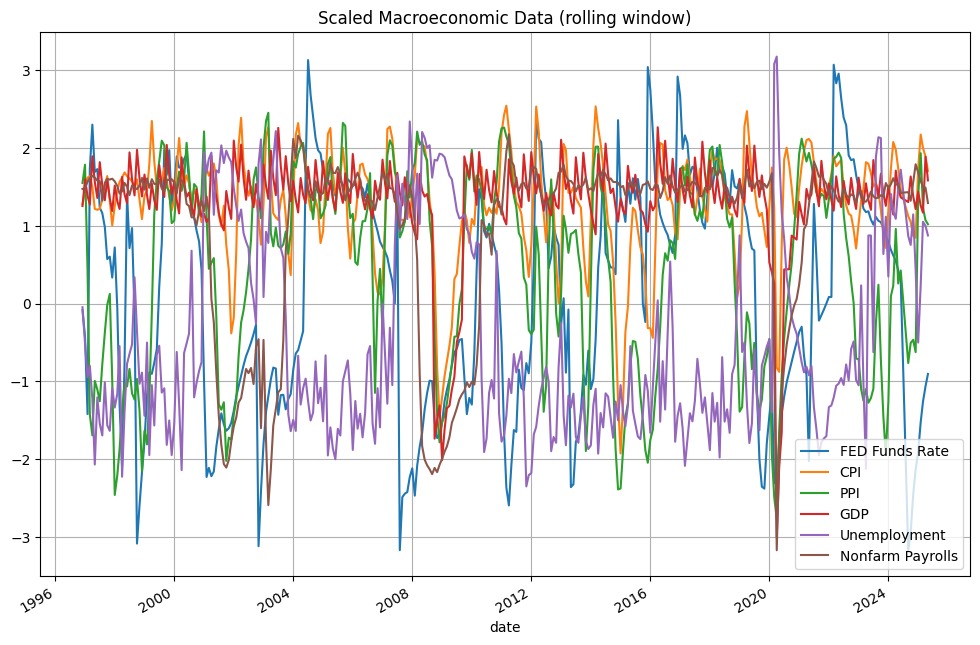

In [110]:
wdw = 12
# scaler = StandardScaler()
# # scaler = MinMaxScaler()
# # scaler = RobustScaler()
# # scaler = MaxAbsScaler()
# scaled_data_df = macrodata.rolling(window=wdw).apply(scaler.fit_transform)
scaled_data_df = ( macrodata - macrodata.rolling(window=wdw).mean() ) / macrodata.rolling(window=wdw).std()
scaled_data_df.dropna(inplace=True)
scaled_data_df.plot(figsize=(12, 8), subplots=False, title='Scaled Macroeconomic Data (rolling window)', grid=True)

# Macroeconomic indices
Since PCA is linear and aims to capture global variance, it excels at decomposing long-run economic regimes. It is highly interpretable and highly relevant when constructing macroeconomic indices.

In [24]:
scaled_data = scaled_data_df.values
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
pca_cols = [f'PC{i+1}' for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_data, columns=pca_cols)
pca_df.index = scaled_data_df.index

In [100]:
threshold = 0.8
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
n_components_thresh = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components explaining {round(threshold*100)}% of the variance: {n_components_thresh} (out of {scaled_data_df.shape[1]} variables)")

Number of components explaining 80% of the variance: 3 (out of 6 variables)


In [101]:
pca_loadings = pd.DataFrame(pca.components_, index=pca_cols, columns=macrodata.columns).mul(100)
pca_loadings["Explained Variance"] = pca.explained_variance_ratio_ * 100
styled_df = (
    pca_loadings
    .style
    .format("{:.2f}%")
    .background_gradient(cmap='coolwarm', vmin=-100, vmax=100, axis=None, subset=pca_loadings.columns[:-1])  # Exclude last col
    .background_gradient(cmap='Greys', vmin=0, vmax=100, subset=['Explained Variance'])  # Custom for Explained Variance
    .set_properties(**{
        'font-size': '15px',
        'padding': '12px',
        'text-align': 'center'
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '18px'), ('padding', '12px')]},
        {'selector': 'td.col_heading.level0', 'props': [('border-right', 'px solid black')]},  # Optional right border
        {'selector': 'td.col_heading.level1', 'props': [('border-right', '2px solid black')]}
    ])
)
styled_df

,FED Funds Rate,CPI,PPI,GDP,Unemployment,Nonfarm Payrolls,Explained Variance
PC1,61.32%,11.31%,20.71%,17.42%,-55.48%,47.97%,48.60%
PC2,-31.18%,34.97%,87.00%,13.27%,7.41%,-2.19%,23.16%
PC3,71.63%,-5.67%,25.16%,-13.17%,42.48%,-47.18%,15.38%
PC4,10.53%,35.68%,-21.54%,43.61%,64.32%,45.97%,6.21%
PC5,2.05%,42.10%,-23.99%,58.32%,-29.88%,-57.92%,3.98%
PC6,4.57%,74.64%,-18.16%,-63.59%,-5.74%,0.86%,2.67%


We performed a naive PCA on the standardized macroeconomic indicators without pre-selecting the number of components. We PCA using the following macroeconomic variables:
- **FED Funds Rate** (Policy)
- **CPI**, **PPI** (Inflation)
- **GDP** (Growth/Output)
- **Unemployment**, **Nonfarm Payrolls** (Labor)

<!-- ---

### ✅ PC1 — Monetary Tightening & Labor Market Strength
- **High positive loadings**:
  - FED Funds Rate, Nonfarm Payrolls
- **Strong negative loading**:
  - Unemployment
- **Moderate positive**:
  - GDP, PPI
- **Interpretation**: A clear **expansion-tightening** dimension. Reflects **strong macro + policy response**. Suitable as a **composite macroeconomic strength index**.

📌 **In summary**: This component captures the **macro cycle**, combining policy tightening (rate hikes), growth (employment, GDP), and low unemployment. Higher PC1 indicates **expansionary phases with policy tightening**.


### ✅ PC2 — Inflationary Pressures
- **Very high positive**: PPI, CPI
- **Moderate negative**: FED Funds Rate
- **Low loadings elsewhere**
- **Interpretation**: Reflects **raw inflation** signal decoupled from central bank action. Useful to **capture price pressure regimes**.

📌 **In summary**: Captures **price pressures from producers** not necessarily matched by central bank response. May indicate **inflationary tensions or lag in policy response**. Possibly linked to **commodity shocks**.


### 🔎 PC3 — Policy/Labor Conflict
- **Strong positive**: FED Funds Rate, Unemployment
- **Strong negative**: Nonfarm Payrolls
- **Mild positive**: GDP
- **Interpretation**: Captures **policy pressure amid labor weakness**. May highlight **policy mistake risk or stagflation setup**.

📌 **In summary**: Indicates a **policy-tightening regime associated with labor market weakening**. Possibly reflects periods of **restrictive policy responses to overheating**, or early-cycle slowdowns.


### ❌ PC4 — Diffuse
- **Positive**: CPI, GDP, Unemployment, Payrolls
- **Negative**: PPI
- **Interpretation**: More diffuse. Potentially **reflation narrative** (rising output & prices) with **mixed labor implications**.
- **Weak macro signal**, but could be monitored.

📌 **In summary**: Captures broad-based **real economic strength**, with synchronized improvements in employment, output, and prices. Could reflect **recovery phases** or **sustained expansions**.


### 🔎 PC5 — Growth-Payroll Divergence
- **Positive**: GDP, CPI
- **Strong negative**: Payrolls, PPI
- **Interpretation**: Captures periods where **growth and employment diverge**, possibly post-shock recoveries or measurement frictions.

📌 **In summary**: Suggests **decoupling between GDP and labor market**. Possibly reflects **productivity gains**, **automation**, or **jobless recoveries**.


### ❌ PC6 — CPI-Only Shock
- **Single strong positive**: CPI
- All other variables low or negative
- **Interpretation**: Looks like **noise or isolated CPI movement**. Not structurally useful.

📌 **In Summary**: Captures episodes of **high consumer inflation amid economic slowdown**. Potentially reflects **stagflation-like scenarios** or **supply-driven inflation** with weak growth.


--- -->

### Index Construction
- **PC1**: Core macro–policy strength signal (main index)
- **PC2**: Orthogonal inflation dimension
- **PC3**: Labor–policy divergence (optional)
- **PC5**: Growth-Payroll Divergence (optional)


<!-- | PC  | Dominant Theme                    | Key Variables                          |
|-----|----------------------------------|----------------------------------------|
| PC1 | Macro Expansion / Tightening     | FED Rate ↑, NFP ↑, Unemp ↓             |
| PC2 | Cost Inflation Pressure          | PPI ↑, CPI ↑, FED Rate ↓               |
| PC3 | Policy vs Labor Conflict         | FED Rate ↑, Unemp ↑, NFP ↓             |
| PC4 | Real Growth Recovery             | GDP ↑, NFP ↑, Unemp ↑                  |
| PC5 | GDP–Employment Decoupling        | GDP ↑, CPI ↑, NFP ↓, Unemp ↓           |
| PC6 | Stagflation / CPI vs Growth      | CPI ↑, GDP ↓, Unemp ↓                  | -->

<Axes: title={'center': 'First Two Principal Components Over Time'}, xlabel='date'>

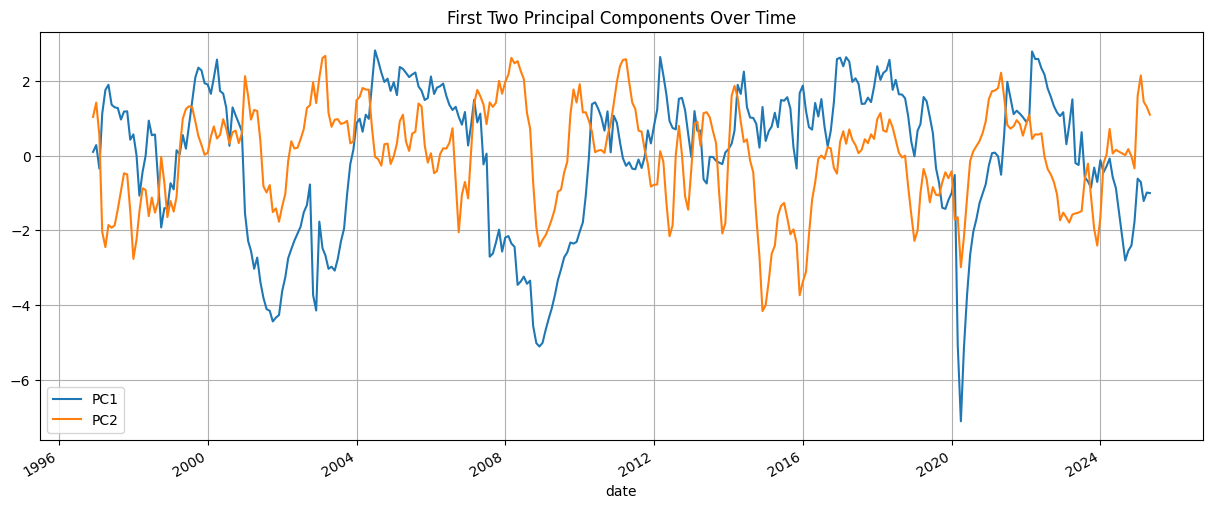

In [28]:
pca_df[['PC1', 'PC2']].plot(figsize=(15, 6), title='First Two Principal Components Over Time', grid=True)

### Change Point Detection: Macro Strength focused

/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_19607/3292947620.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


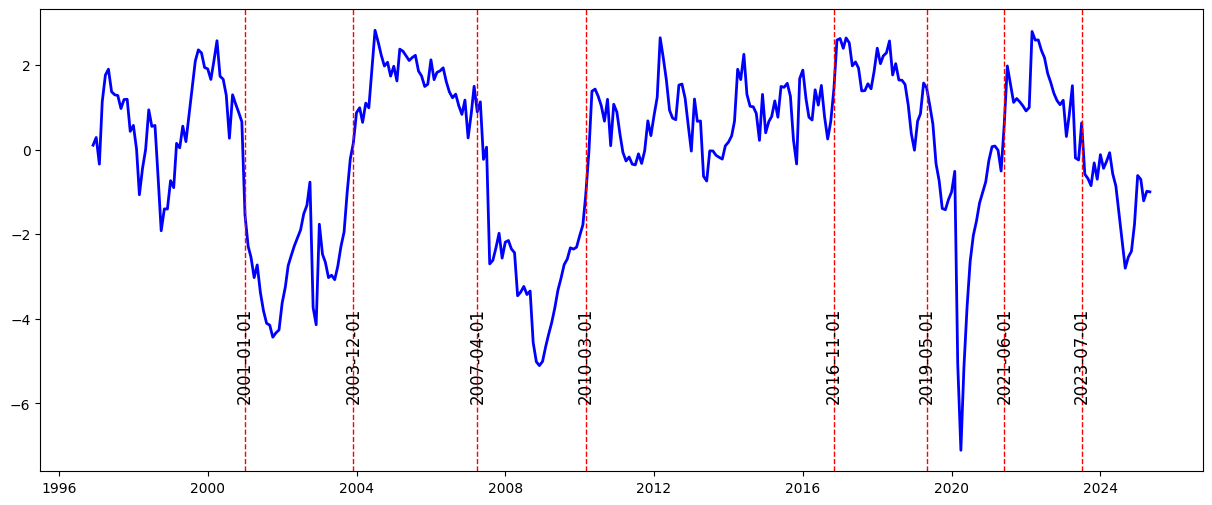

In [129]:
macro_index = pca_df['PC1']
algo = rpt.Pelt(model="rbf").fit(macro_index.values)
breaks_macro = algo.predict(pen=4)[:-1] # Penalty controls number of breaks; tune as needed
break_dates_macro = [macro_index.index[i-1] for i in breaks_macro]

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(macro_index.index, macro_index.values, label="Macro Strength Index", color='blue', linewidth=2)
for i in range(len(break_dates_macro)):
    ax.axvline(x=break_dates_macro[i], color='red', linestyle='--', linewidth=1)
    ax.text(break_dates_macro[i], -6, break_dates_macro[i].strftime('%Y-%m-%d'), rotation=90, ha='center', va='bottom', fontsize=12)
fig.show()

/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_19607/2656215271.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


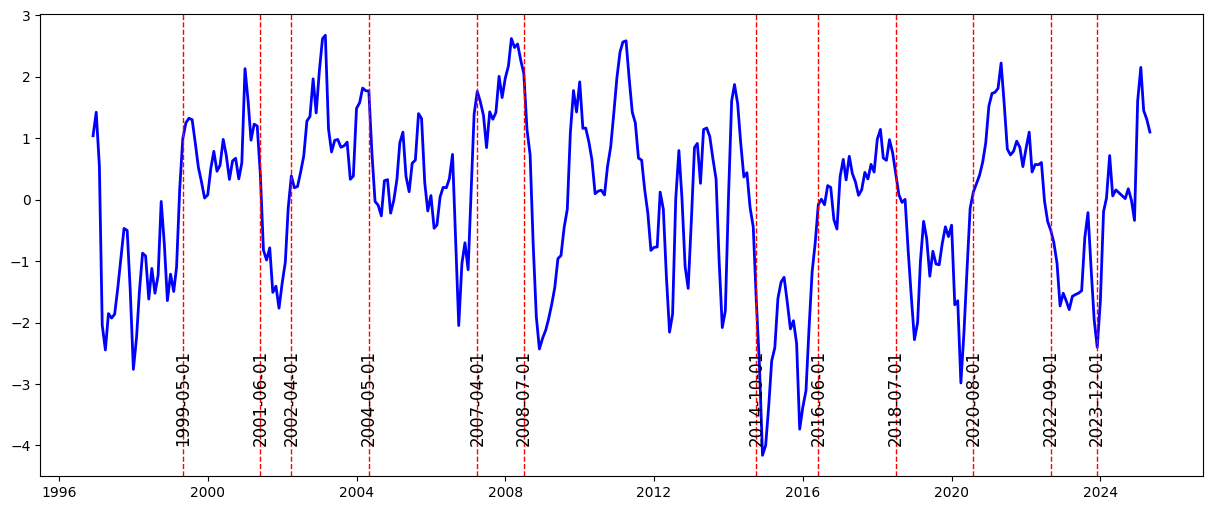

In [246]:
inflation_index = pca_df['PC2']
algo = rpt.Pelt(model="rbf").fit(inflation_index.values)
breaks_inflation = algo.predict(pen=4)[:-1] # Penalty controls number of breaks; tune as needed
break_dates_inflation = [inflation_index.index[i-1] for i in breaks_inflation]

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(inflation_index.index, inflation_index.values, label="Inflation Index", color='blue', linewidth=2)
for i in range(len(break_dates_inflation)):
    ax.axvline(x=break_dates_inflation[i], color='red', linestyle='--', linewidth=1)
    ax.text(break_dates_inflation[i], -4, break_dates_inflation[i].strftime('%Y-%m-%d'), rotation=90, ha='center', va='bottom', fontsize=12)
fig.show()

# US Central Bank Speeches

In [248]:
us_speeches = pd.read_parquet("gigando_speeches_ner_v2.parquet")
us_speeches.set_index('datetime', inplace=True)
us_speeches = us_speeches[us_speeches['country_code'] == 'US']
us_speeches["hawkish"] = 0
us_speeches.loc[us_speeches['sentiment'] == 'hawkish', 'hawkish'] = 1
us_speeches["dovish"] = 0
us_speeches.loc[us_speeches['sentiment'] == 'dovish', 'dovish'] = 1

/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_19607/586779662.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(us_speeches_monthly.index.strftime('%Y-%m'))#, rotation=90)


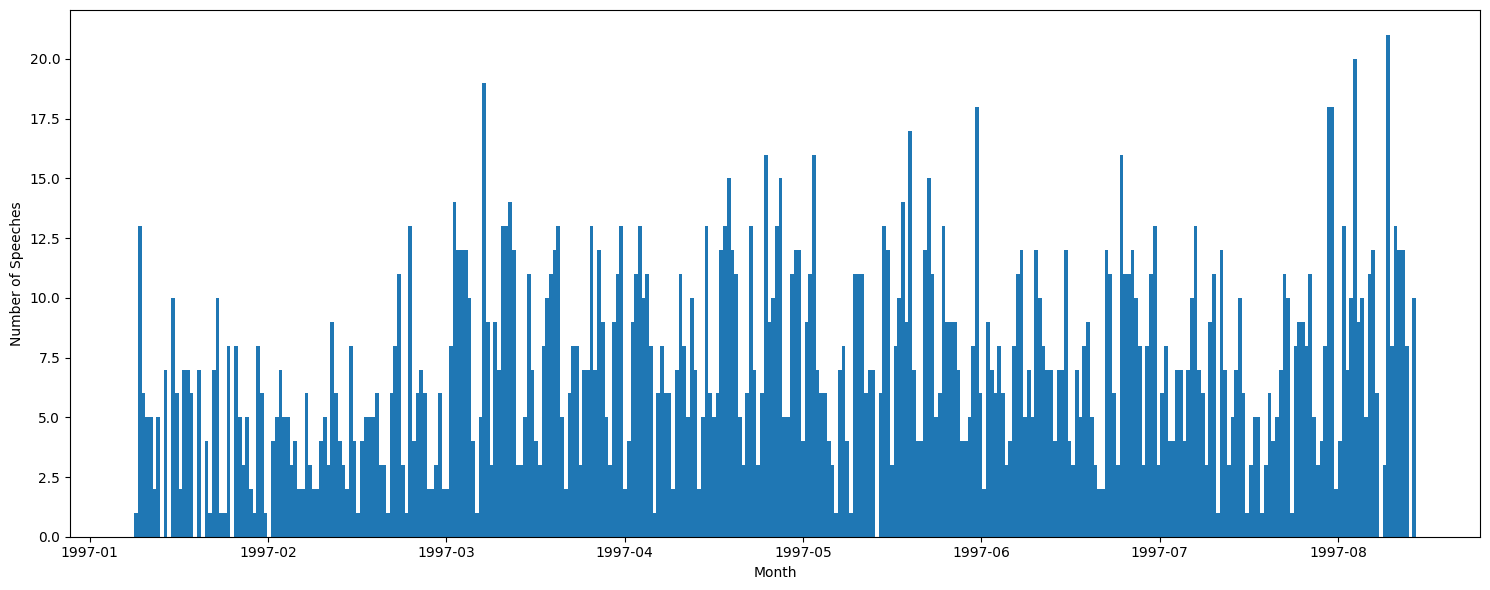

In [ ]:
us_speeches_monthly = us_speeches.resample('ME').size()

fig, ax = plt.subplots(figsize=(15, 6))
ax.hist(us_speeches_monthly.index, weights=us_speeches_monthly.values, bins=len(us_speeches_monthly.index))
ax.set_xlabel('Month')
ax.set_ylabel('Number of Speeches')
# ax.set_xticks(us_speeches_monthly.index.year.unique())
ax.set_xticklabels(us_speeches_monthly.index.strftime('%Y-%m'))#, rotation=90)
plt.tight_layout()
plt.show()

del us_speeches_monthly

In [304]:
cb_sentiment = us_speeches[["hawkish", "dovish"]].copy()
cb_sentiment.index = cb_sentiment.index.date
cb_sentiment = cb_sentiment.groupby(cb_sentiment.index).sum()
cb_sentiment = cb_sentiment.reindex(pd.date_range(START_DATE, END_DATE, freq='D')).fillna(0.0)#.shift()
# cb_sentiment = cb_sentiment.rolling(365).sum()
cb_sentiment = cb_sentiment.resample('MS').sum().shift() # Resample to month-start and shift to avoid lookahead bias
cb_sentiment = ( cb_sentiment - cb_sentiment.rolling(window=12).mean() ) / cb_sentiment.rolling(window=12).std()

/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_19607/3685453460.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


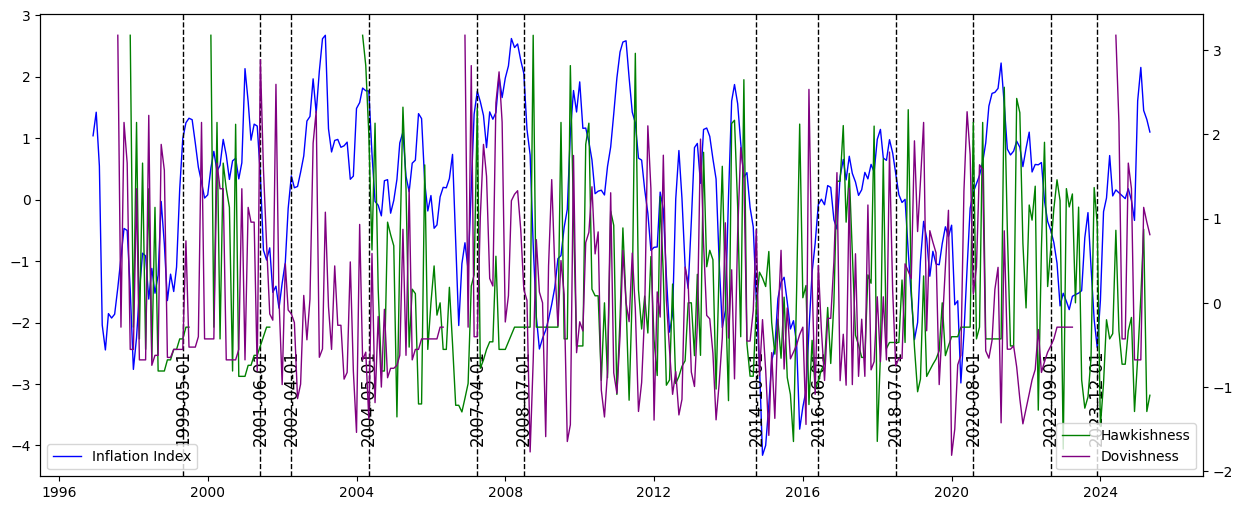

In [305]:
fig, ax = plt.subplots(figsize=(15, 6))

# ax.plot(macro_index.index, macro_index.values, label="Macro Strength Index", color='blue', linewidth=1)
# for i in range(len(break_dates_macro)):
#     ax.axvline(x=break_dates_macro[i], color='black', linestyle='--', linewidth=1)
#     ax.text(break_dates_macro[i], -6, break_dates_macro[i].strftime('%Y-%m-%d'), rotation=90, ha='center', va='bottom', fontsize=12)
ax.plot(inflation_index.index, inflation_index.values, label="Inflation Index", color='blue', linewidth=1)
for i in range(len(break_dates_inflation)):
    ax.axvline(x=break_dates_inflation[i], color='black', linestyle='--', linewidth=1)
    ax.text(break_dates_inflation[i], -4, break_dates_inflation[i].strftime('%Y-%m-%d'), rotation=90, ha='center', va='bottom', fontsize=12)
ax.legend(loc='lower left')

ax2 = ax.twinx()
ax2.plot(cb_sentiment.index, cb_sentiment['hawkish'], label="Hawkishness", color='green', linewidth=1)
ax2.plot(cb_sentiment.index, cb_sentiment['dovish'], label="Dovishness", color='purple', linewidth=1)
ax2.legend(loc='lower right')

fig.show()

In [306]:
def beta_1pred(
    factors: pd.DataFrame,
    assets: pd.DataFrame,
    window: int = 252,
    min_periods: Optional[int] = None,
    expanding: bool = False,
    adj_rsquared: bool = False,
    dtype: str = "float32",
) -> Tuple[Dict[str, pd.DataFrame], Dict[str, pd.DataFrame], Dict[str, pd.DataFrame]]:
    """
    Compute OLS betas (with intercept), contemporaneous signals (beta_t * factor_t),
    and rolling R² between each factor and each asset.

    Parameters
    ----------
    factors, assets : aligned DataFrames of returns
    window          : rolling window size
    expanding       : use expanding instead of rolling
    dtype           : numeric type for efficiency

    Returns
    -------
    betas_dict      : {factor -> DataFrame of betas}
    signals_dict    : {factor -> DataFrame of beta_t * factor_t}
    r2_dict         : {factor -> DataFrame of rolling R²}
    """
    if min_periods is None:
        min_periods = window

    factors = factors.astype(dtype)
    assets  = assets.astype(dtype)

    betas_dict: Dict[str, pd.DataFrame] = {}
    r2_dict: Dict[str, pd.DataFrame] = {}

    for fac in factors.columns:
        x = factors[fac]

        if expanding:
            cov_ax = assets.expanding(min_periods=min_periods).cov(x)
            var_x  = x.expanding(min_periods=min_periods).var()
            var_y  = assets.expanding(min_periods=min_periods).var()
        else:
            cov_ax = assets.rolling(window, min_periods=min_periods).cov(x)
            var_x  = x.rolling(window, min_periods=min_periods).var()
            var_y  = assets.rolling(window, min_periods=min_periods).var()

        # β = Cov(x, y) / Var(x)
        beta = cov_ax.div(var_x, axis=0) # centered ⇒ OLS without intercept
        betas_dict[fac] = beta

        # Adjusted R² = 1 - (1 - R²) * (n - 1) / (n - k - 1), with k=1
        if adj_rsquared:
            n_obs = assets.rolling(window, min_periods=min_periods).count()
            r2_dict[fac] = 1 - (1 - (cov_ax ** 2).div(var_y.mul(var_x, axis=0), axis=0)) * (n_obs - 1) / (n_obs - 1 - 1)
        
        # R² = Cov(x, y)² / (Var(x) * Var(y))
        else:
            r2_dict[fac] = (cov_ax ** 2).div(var_y.mul(var_x, axis=0), axis=0)

    return betas_dict, r2_dict

### Macro Economic Index vs. Hawkish/dovishness

In [ ]:
df = pd.merge(macro_index.rename("Macro Index"), cb_sentiment, left_index=True, right_index=True, how='outer').ffill().dropna()
df = df.diff().dropna()
betas_dict, r2_dict = beta_1pred(factors=df[["hawkish", "dovish"]], assets=df[["Macro Index"]], window=3*12, expanding=False, adj_rsquared=False, dtype="float32")

In [308]:
for col in df.columns:
    print(col, '---', df[col].autocorr(lag=1))
    # pd.plotting.autocorrelation_plot(df[col])
df.corr()

Macro Index --- 0.05209777318723375
hawkish --- -0.4299188376268943
dovish --- -0.3799230112389488


,Macro Index,hawkish,dovish
Macro Index,1.000000,0.005418,0.005385
hawkish,0.005418,1.000000,0.098202
dovish,0.005385,0.098202,1.000000


/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_19607/2931630052.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


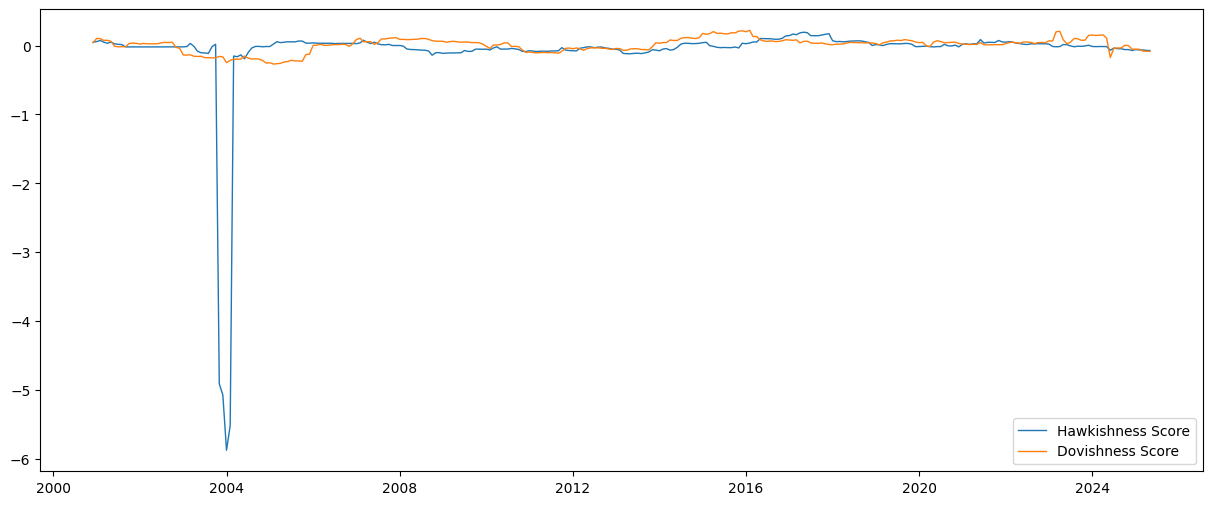

In [315]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(betas_dict["hawkish"].index, betas_dict["hawkish"].values, label="Hawkishness Score", linewidth=1)
ax.plot(betas_dict["dovish"].index, betas_dict["dovish"].values, label="Dovishness Score", linewidth=1)
ax.legend()
fig.show()

/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_19607/2493099950.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


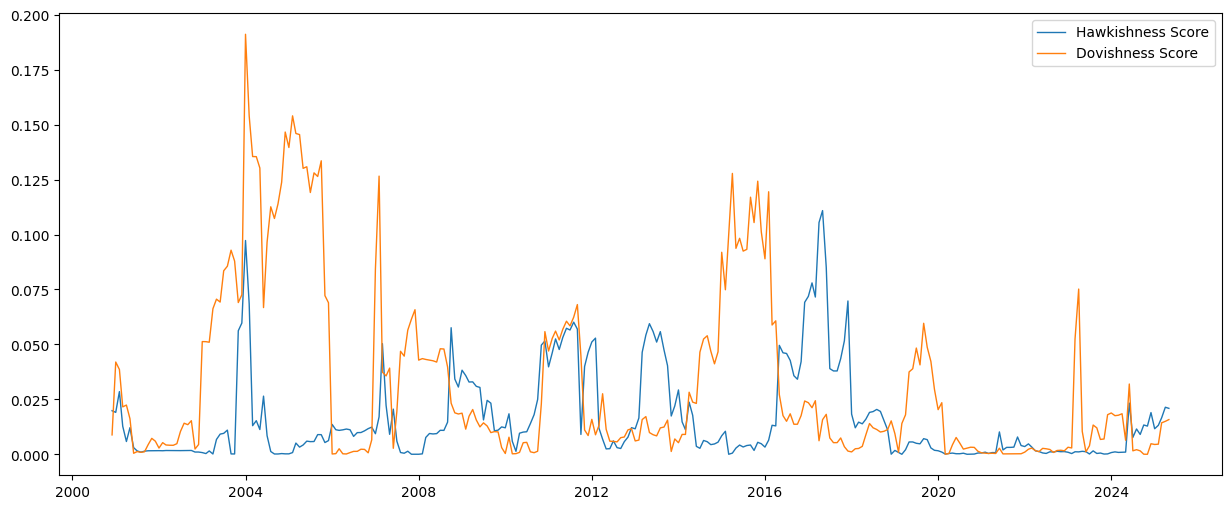

In [314]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(r2_dict["hawkish"].index, r2_dict["hawkish"].values, label="Hawkishness Score", linewidth=1)
ax.plot(r2_dict["dovish"].index, r2_dict["dovish"].values, label="Dovishness Score", linewidth=1)
ax.legend()
fig.show()

### Inflation Index vs. Hawkish/dovishness

In [316]:
df = pd.merge(inflation_index.rename("Inflation Index"), cb_sentiment, left_index=True, right_index=True, how='outer').ffill().dropna()
df = df.diff().dropna()
betas_dict, r2_dict = beta_1pred(factors=df[["hawkish", "dovish"]], assets=df[["Inflation Index"]], window=3*12, expanding=False, adj_rsquared=False, dtype="float32")

In [317]:
for col in df.columns:
    print(col, '---', df[col].autocorr(lag=1))
    # pd.plotting.autocorrelation_plot(df[col])
df.corr()

Inflation Index --- 0.28847240646358996
hawkish --- -0.4299188376268943
dovish --- -0.3799230112389488


,Inflation Index,hawkish,dovish
Inflation Index,1.000000,0.002618,-0.025929
hawkish,0.002618,1.000000,0.098202
dovish,-0.025929,0.098202,1.000000


/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_19607/2931630052.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


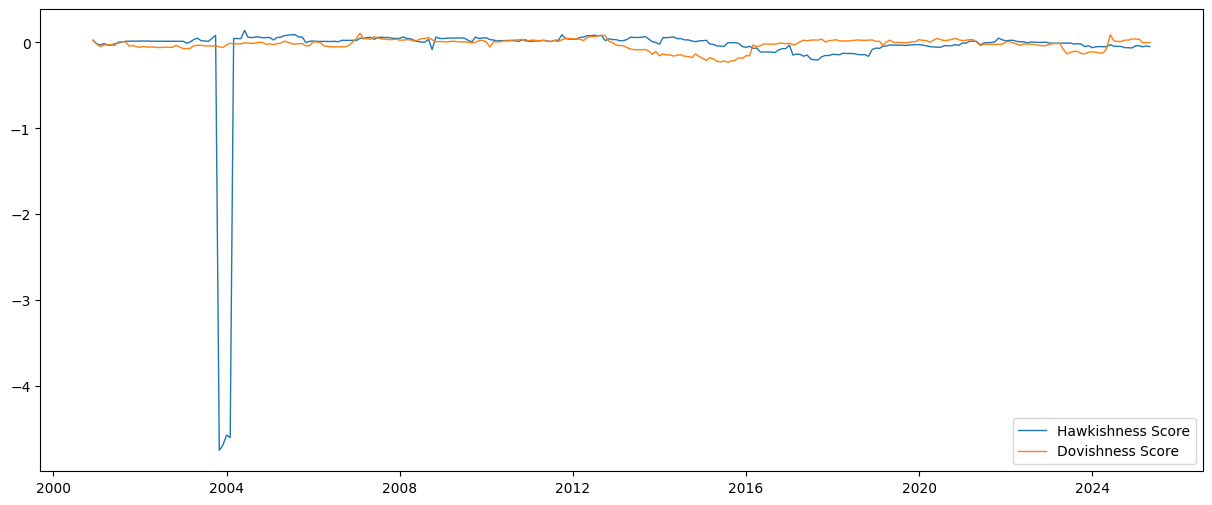

In [318]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(betas_dict["hawkish"].index, betas_dict["hawkish"].values, label="Hawkishness Score", linewidth=1)
ax.plot(betas_dict["dovish"].index, betas_dict["dovish"].values, label="Dovishness Score", linewidth=1)
ax.legend()
fig.show()

/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_19607/2493099950.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


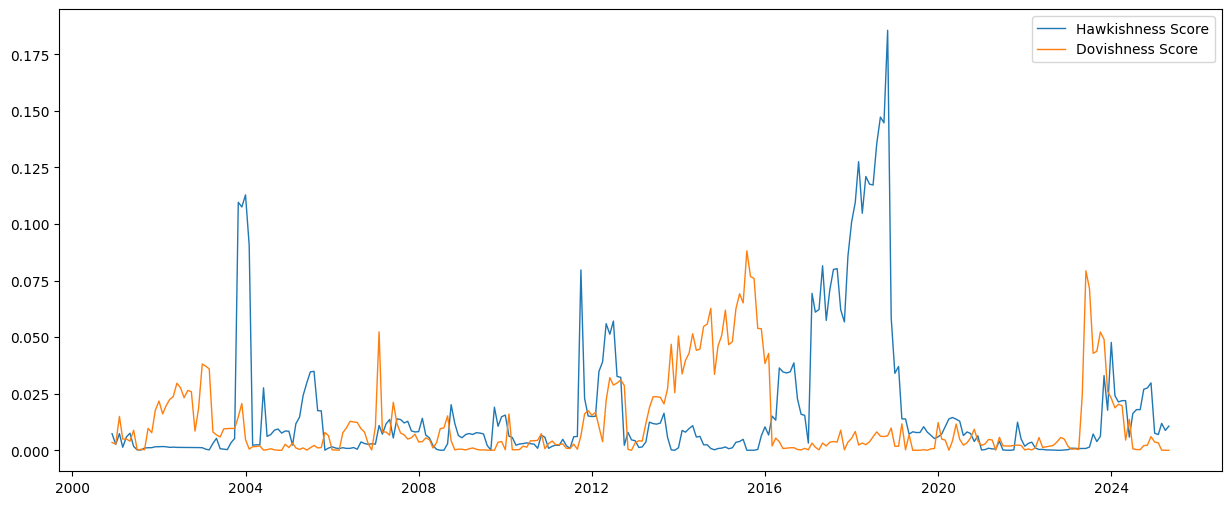

In [319]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(r2_dict["hawkish"].index, r2_dict["hawkish"].values, label="Hawkishness Score", linewidth=1)
ax.plot(r2_dict["dovish"].index, r2_dict["dovish"].values, label="Dovishness Score", linewidth=1)
ax.legend()
fig.show()